In [113]:
import math
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
import transformers
from transformers import BertForTokenClassification, AdamW

MAX_LEN = 75
bs = 32
epochs = 3
max_grad_norm = 1.0


### DATA Ecoding

In [87]:
train_data = pd.read_csv("/home/jovyan/work/data/label_data/newner_train_data.csv")
train_data = train_data[:1000]
test_data = pd.read_csv("/home/jovyan/work/data/label_data/newner_test_data.csv")

In [88]:
train_data.head(10)

,sentence_idx,word,pos,tag
0,7708,The,DT,O
1,7708,58-year-old,JJ,O
2,7708,former,JJ,O
3,7708,analyst,NN,O
4,7708,says,VBZ,O
5,7708,he,PRP,O
6,7708,provided,VBD,O
7,7708,information,NN,O
8,7708,to,TO,O
9,7708,an,DT,O


In [89]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [90]:
getter = SentenceGetter(train_data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['Authorities',
 'in',
 'Mogadishu',
 'have',
 'not',
 'determined',
 'a',
 'motive',
 'for',
 'the',
 'shooting',
 '.']

In [91]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [92]:
tag_values = list(set(train_data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [93]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

# GPU??
# torch.cuda.get_device_name(0)


In [94]:
# tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens. For example ‘gunships’ will be split in the two tokens ‘guns’ and ‘##hips’. We have to deal with the issue of splitting our token-level labels to related subtokens.

In [95]:
# load the pretrain model "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [96]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        if isinstance(word, float) and math.isnan(word):
            word = "NaN"

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [97]:
# tokenized_texts_and_labels = [
#     tokenize_and_preserve_labels(sent, labs)
#     for sent, labs in zip(sentences, labels)
# ]

tokenized_texts_and_labels = []
for sent, labs in zip(sentences, labels):
    tokenized_sentence, tokenized_labels = tokenize_and_preserve_labels(sent, labs)
    tokenized_texts_and_labels.append((tokenized_sentence, tokenized_labels))



In [98]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [99]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [100]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [101]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


# Now we split the dataset to use 10% to validate the model.


In [102]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [138]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


/tmp/ipykernel_94/1947240576.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_inputs = torch.tensor(tr_inputs)
/tmp/ipykernel_94/1947240576.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(val_inputs)
/tmp/ipykernel_94/1947240576.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_tags = torch.tensor(tr_tags)
/tmp/ipykernel_94/1947240576.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

In [139]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# Initial the model

In [140]:
transformers.__version__

'4.28.1'

In [107]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [108]:
# model.cuda();

In [110]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [114]:

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [115]:
from seqeval.metrics import f1_score, accuracy_score


### Finally, we can finetune the model. A few epochs should be enougth. The paper suggest 3-4 epochs.

In [119]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # clear any previously calculated gradients before performing a backward pass
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # # ========================================
    # #               Validation
    # # ========================================
    # # After the completion of each training epoch, measure our performance on
    # # our validation set.
    #
    # # Put the model into evaluation mode
    # model.eval()
    # # Reset the validation loss for this epoch.
    # eval_loss, eval_accuracy = 0, 0
    # nb_eval_steps, nb_eval_examples = 0, 0
    # predictions , true_labels = [], []
    # for batch in valid_dataloader:
    #     batch = tuple(t.to(device) for t in batch)
    #     b_input_ids, b_input_mask, b_labels = batch
    #
    #     # Telling the model not to compute or store gradients,
    #     # saving memory and speeding up validation
    #     with torch.no_grad():
    #         # Forward pass, calculate logit predictions.
    #         # This will return the logits rather than the loss because we have not provided labels.
    #         outputs = model(b_input_ids, token_type_ids=None,
    #                         attention_mask=b_input_mask, labels=b_labels)
    #     # Move logits and labels to CPU
    #     logits = outputs[1].detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()
    #
    #     # Calculate the accuracy for this batch of test sentences.
    #     eval_loss += outputs[0].mean().item()
    #     predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    #     true_labels.extend(label_ids)
    #
    # eval_loss = eval_loss / len(valid_dataloader)
    # validation_loss_values.append(eval_loss)
    # print("Validation loss: {}".format(eval_loss))
    # pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
    #                               for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    # valid_tags = [tag_values[l_i] for l in true_labels
    #                               for l_i in l if tag_values[l_i] != "PAD"]
    # print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    # print()


Epoch:  33%|███▎      | 1/3 [00:10<00:21, 10.68s/it]

Average train loss: 1.4998719692230225


Epoch:  67%|██████▋   | 2/3 [00:20<00:10, 10.19s/it]

Average train loss: 1.4709582328796387


Epoch: 100%|██████████| 3/3 [00:31<00:00, 10.38s/it]

Average train loss: 1.491879165172577


In [135]:
## Store the average loss after each epoch so we can plot them.
validation_loss_values = []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                  for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]


    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))

Epoch:  33%|███▎      | 1/3 [00:00<00:00,  2.40it/s]

Validation loss: 1.4147568941116333
Validation Accuracy: 0.0
Validation F1-Score: 0.0


Epoch:  67%|██████▋   | 2/3 [00:01<00:00,  1.88it/s]

Validation loss: 1.4147568941116333
Validation Accuracy: 0.0
Validation F1-Score: 0.0


Epoch: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

Validation loss: 1.4147568941116333
Validation Accuracy: 0.0
Validation F1-Score: 0.0


In [134]:
print(len(valid_tags),len(pred_tags))
print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))

136 136
Validation Accuracy: 0.0


 ### Visualize the training loss

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


### Evaluation

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# ...

for batch in valid_dataloader:
    # ...

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(valid_dataloader)
validation_loss_values.append(eval_loss)
print("Validation loss: {}".format(eval_loss))

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
             for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
              for l_i in l if tag_values[l_i] != "PAD"]

# Calculate precision, recall, and F1-score for each tag
tag_precision = precision_score(valid_tags, pred_tags, average=None)
tag_recall = recall_score(valid_tags, pred_tags, average=None)
tag_f1score = f1_score(valid_tags, pred_tags, average=None)

for tag, precision, recall, f1 in zip(tag_values, tag_precision, tag_recall, tag_f1score):
    print(f"Tag: {tag}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print()


Validation loss: 0.03125120648868485


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tag: B-tim
Precision: 0.3333333333333333
Recall: 0.06896551724137931
F1-Score: 0.1142857142857143

Tag: I-nat
Precision: 0.5384615384615384
Recall: 0.23333333333333334
F1-Score: 0.32558139534883723

Tag: B-art
Precision: 0.7602905569007264
Recall: 0.8703302000482044
F1-Score: 0.811597460246109

Tag: B-per
Precision: 0.8743862520458265
Recall: 0.945575221238938
F1-Score: 0.9085884353741497

Tag: I-gpe
Precision: 0.3333333333333333
Recall: 0.0625
F1-Score: 0.10526315789473684

Tag: I-per
Precision: 0.8524962178517398
Recall: 0.7664059843590616
F1-Score: 0.8071620411817368

Tag: I-art
Precision: 0.8099616858237548
Recall: 0.8762088974854932
F1-Score: 0.8417839129280594

Tag: B-nat
Precision: 0.9030596788851863
Recall: 0.8563631140476875
F1-Score: 0.8790917133588912

Tag: I-org
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Tag: I-geo
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Tag: B-gpe
Precision: 0.7742755465175394
Recall: 0.9130695443645084
F1-Score: 0.8379642365887208

Tag: I-tim
Precision: 

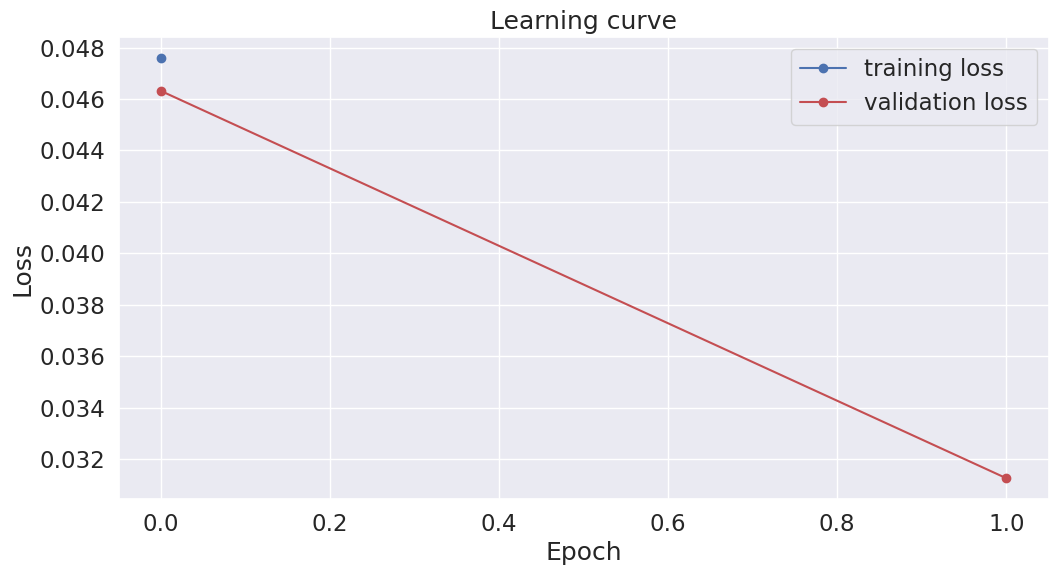

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
